# NB2_Predict Recommendations
- It is a work in progress
- Need to work on describing interpretability and further optimizing

In [1]:
import numpy as np
import pandas as pd

In [2]:
reviews_features = pd.read_csv("reviews_features.csv")
print(reviews_features.shape)
reviews_features.head()
# Remove rows with missing values in the target variable 'Recommend Flag'
reviews_features = reviews_features.dropna(subset=['Recommend Flag'])
print(reviews_features.shape)
reviews_features = reviews_features.dropna(subset=['Rating'])
print(reviews_features.shape)

(23472, 18)
(23472, 18)
(23472, 18)


In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Select columns for each transformation type
predicts = ['Rating', 'Recommend Flag']
labels = ['Product ID']
categorical_cols = ['Category', 'Subcategory1', 'SubCategory2', 'Location', 'Channel', 'age_bins', ]
numeric_cols = ['review_len', 'noun_strength', 'polarity', 'subjectivity_score', 'compound_VADER_score', 'unique_word_fraction'] 
binary_cols = ['is_gibberish']

# One-Hot Encoding for categorical features
ohe = OneHotEncoder(sparse_output=False, drop='first') 
categorical_encoded = ohe.fit_transform(reviews_features[categorical_cols])

# Create DataFrame with OHE features
ohe_df = pd.DataFrame(categorical_encoded, columns=ohe.get_feature_names_out(categorical_cols))

# Scaling numerical features
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(reviews_features[numeric_cols])

# Create DataFrame with scaled numerical features
numeric_df = pd.DataFrame(numeric_scaled, columns=numeric_cols)

# Combine all features into a final DataFrame
reviewsFE_final_df = pd.concat([ohe_df, numeric_df, reviews_features[binary_cols].reset_index(drop=True)], axis=1)


reviewsFE_final_df = pd.concat([reviewsFE_final_df, reviews_features[['Product ID','Rating', 'Recommend Flag']]], axis=1)

to_drop = ['Product ID','Rating', 'Recommend Flag']

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_features['lemmatized'])
words_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
words_df

,00,0p,10,100,11,110,115,12,120,125,...,xxs,xxsp,year,yellow,yes,yesterday,yoga,young,zip,zipper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178721,0.164051
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
23470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [5]:
reviewsFE_final_df = pd.concat([reviewsFE_final_df, words_df], axis=1)

# Reset index and show the final DataFrame
reviewsFE_final_df.reset_index(drop=True, inplace=True)

# Display the final DataFrame
print(reviewsFE_final_df.columns)

Index(['Category_General Petite', 'Category_Initmates', 'Subcategory1_Dresses',
       'Subcategory1_Intimate', 'Subcategory1_Jackets', 'Subcategory1_Tops',
       'Subcategory1_Trend', 'SubCategory2_Casual bottoms',
       'SubCategory2_Chemises', 'SubCategory2_Dresses',
       ...
       'xxs', 'xxsp', 'year', 'yellow', 'yes', 'yesterday', 'yoga', 'young',
       'zip', 'zipper'],
      dtype='object', length=1045)


In [6]:
from sklearn.model_selection import train_test_split

X = reviewsFE_final_df.drop(columns=to_drop)
y = reviewsFE_final_df['Recommend Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
lr_classifier = LogisticRegression(max_iter=5000)
lr_classifier.fit(X_train,y_train)
print("Training Accuracy\n", accuracy_score(y_train,lr_classifier.predict(X_train)))
print("Test Accuracy\n", accuracy_score(y_test,lr_classifier.predict(X_test)))

print('CLASSIFICATION REPORT: Logistic Regression')
print("Training\n", classification_report(y_train,lr_classifier.predict(X_train)))
print("Test \n", classification_report(y_test,lr_classifier.predict(X_test)))

Training Accuracy
 0.9041912978644085
Test Accuracy
 0.8881789137380192
CLASSIFICATION REPORT: Logistic Regression
Training
               precision    recall  f1-score   support

           0       0.81      0.59      0.69      3309
           1       0.92      0.97      0.94     15468

    accuracy                           0.90     18777
   macro avg       0.87      0.78      0.81     18777
weighted avg       0.90      0.90      0.90     18777

Test 
               precision    recall  f1-score   support

           0       0.78      0.54      0.64       863
           1       0.90      0.97      0.93      3832

    accuracy                           0.89      4695
   macro avg       0.84      0.76      0.79      4695
weighted avg       0.88      0.89      0.88      4695



In [8]:
coefficients = lr_classifier.coef_
print(coefficients)

[[ 0.05019327  0.48426265  0.02145613 ...  0.148107    0.40423211
  -0.67162565]]


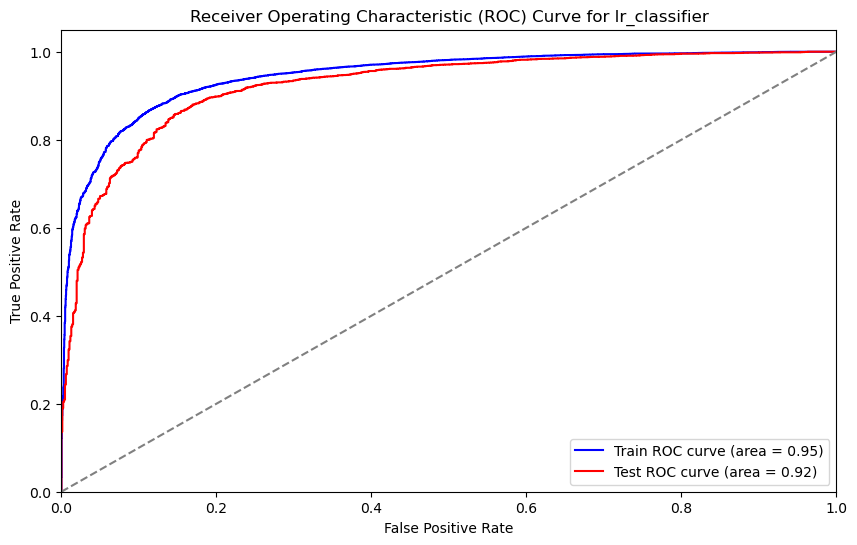

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Make probabilistic predictions
y_train_prob = lr_classifier.predict_proba(X_train)[:, 1]  
y_test_prob = lr_classifier.predict_proba(X_test)[:, 1]  

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

# Compute AUC scores
auc_train = roc_auc_score(y_train, y_train_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for lr_classifier')
plt.legend(loc='lower right')
plt.show()

In [10]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train,y_train)

print("Training Accuracy\n", accuracy_score(y_train,dt_classifier.predict(X_train)))
print("Test Accuracy\n", accuracy_score(y_test,dt_classifier.predict(X_test)))

print('CLASSIFICATION REPORT: Decision Trees')
print("Training\n", classification_report(y_train,dt_classifier.predict(X_train)))
print("Test \n", classification_report(y_test,dt_classifier.predict(X_test)))

Training Accuracy
 0.9982425307557118
Test Accuracy
 0.8087326943556975
CLASSIFICATION REPORT: Decision Trees
Training
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3309
           1       1.00      1.00      1.00     15468

    accuracy                           1.00     18777
   macro avg       1.00      1.00      1.00     18777
weighted avg       1.00      1.00      1.00     18777

Test 
               precision    recall  f1-score   support

           0       0.48      0.47      0.48       863
           1       0.88      0.88      0.88      3832

    accuracy                           0.81      4695
   macro avg       0.68      0.68      0.68      4695
weighted avg       0.81      0.81      0.81      4695



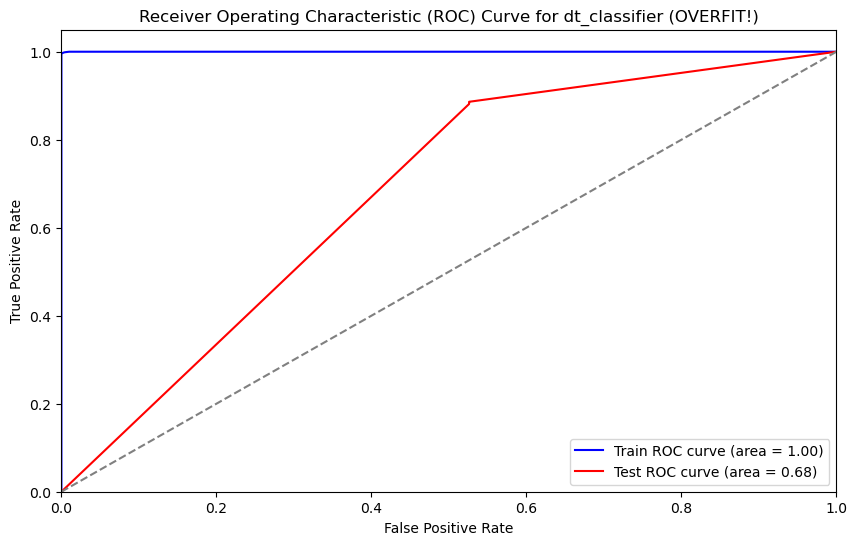

In [11]:
y_train_prob = dt_classifier.predict_proba(X_train)[:, 1]  
y_test_prob = dt_classifier.predict_proba(X_test)[:, 1]  

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

# Compute AUC scores
auc_train = roc_auc_score(y_train, y_train_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for dt_classifier (OVERFIT!)')
plt.legend(loc='lower right')
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc_classifier = RandomForestClassifier(n_estimators=50, n_jobs = -1, oob_score = True,random_state=42)
rfc_classifier.fit(X_train,y_train)

print("Training Accuracy\n", accuracy_score(y_train,rfc_classifier.predict(X_train)))
print("Test Accuracy\n", accuracy_score(y_test,rfc_classifier.predict(X_test)))

print('CLASSIFICATION REPORT: Random Forest Classifier')
print("Training\n", classification_report(y_train,rfc_classifier.predict(X_train)))
print("Test \n", classification_report(y_test,rfc_classifier.predict(X_test)))

Training Accuracy
 0.9981360174681791
Test Accuracy
 0.8692225772097977
CLASSIFICATION REPORT: Random Forest Classifier
Training
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3309
           1       1.00      1.00      1.00     15468

    accuracy                           1.00     18777
   macro avg       1.00      1.00      1.00     18777
weighted avg       1.00      1.00      1.00     18777

Test 
               precision    recall  f1-score   support

           0       0.78      0.40      0.53       863
           1       0.88      0.97      0.92      3832

    accuracy                           0.87      4695
   macro avg       0.83      0.69      0.73      4695
weighted avg       0.86      0.87      0.85      4695



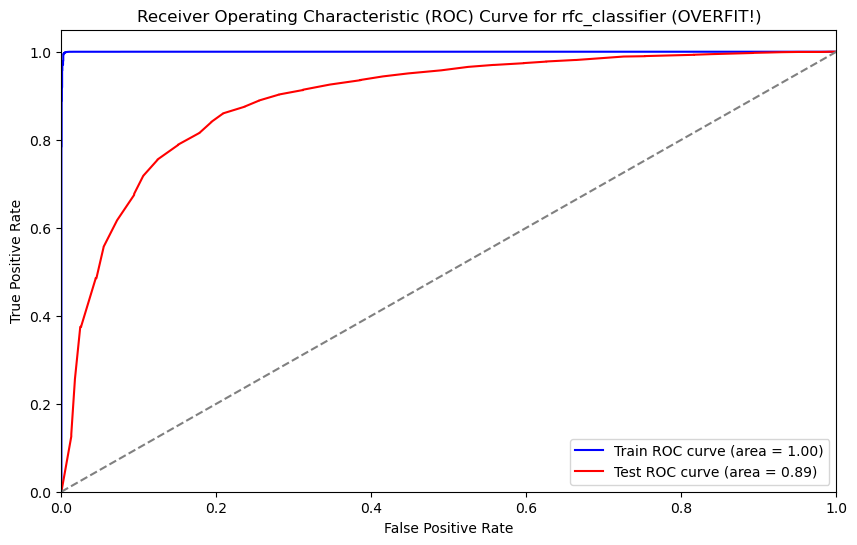

In [13]:
y_train_prob = rfc_classifier.predict_proba(X_train)[:, 1]  
y_test_prob = rfc_classifier.predict_proba(X_test)[:, 1]  

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

# Compute AUC scores
auc_train = roc_auc_score(y_train, y_train_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC curve (area = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for rfc_classifier (OVERFIT!)')
plt.legend(loc='lower right')
plt.show()